In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Concentration Dynamics for the Liquid Suspended Cultures

We will simulate the concentration dynamics of a liquid suspended culture with two species, cyanobacteria and methanotrophs, competing for resources. 

![Reaction Scheme](reaction_scheme.png "Reaction Scheme")

The mathematical relationships between the instantaneous concentrations of the species and the reaction rates are as follows:
$$
\begin{aligned}
\text{Bacterial Proliferation Rates:} && \frac{\mathrm{d}}{\mathrm{d}t}c_{🦠} &= \mu_{🦠}(c_{\cdots}) \cdot c_{🦠} && \text{(I)}
\\\text{Multiplicative Monod Model:} && &\quad~ \mu_{🦠}(c_\cdots) = \mu_{\max,🦠} \cdot \prod_{🧪} \frac{c_{🧪}}{c^\text{half}_{🦠,🧪} + c_{🧪}}
\\\text{Nutrient Consumption Rates:} && \frac{\mathrm{d}}{\mathrm{d}t} c_{🧪} &= \frac{-1}{Y_{🦠\leftarrow🧪}} \cdot \mu_{🦠}(c_\cdots) \cdot c_{🦠} && \text{(II)}
\\\text{Gas Production:} && \frac{\mathrm{d}}{\mathrm{d}t}c_{🧪} &= \underbrace{ \alpha_{🦠\to🧪} \cdot \mu_{🦠}(c_\cdots) \cdot c_{🦠} }_{ \text{growth-associated} } + \underbrace{ \beta_{🦠\to🧪} \cdot c_{🦠} }_{ \text{non-growth-associated} } && \text{(III)}
\\\text{Gas Exchange:} && \frac{\mathrm{d}}{\mathrm{d}t} c_{🧪} &= k_{\text{La},🧪} \cdot \left( \frac{p_{🧪}}{H_{🧪}} - c_{🧪} \right) && \text{(IV)}
\end{aligned}
$$
Here, 🦠 indicates any bacterial species and 🧪 indicates any nutrient species. 

In [3]:
# needed to package into proper function for some weird late binding reason
def make_monod_function(c_half):
    if c_half is None:
        return lambda c : 1.0 if c > 0 else 0.0
    else: 
        return lambda c : max( 0, ( c / ( c_half + c ) ) )

## Parameters
The system depends on a set of parameters, some of which are specific to the biological and chemical species involved, while others are able to be adjusted in the experiment. In terms of the mathematical model, these parameters are categorized as follows:

**Dependent Variables:**
- $c_{🦠}$: Concentration of the bacterial species 🦠.
- $c_{🧪}$: Concentration of the nutrient species 🧪.

**Independent Variables:**
- $t$: Time variable. (Not actually used in the model, but included for completeness.)

**Initial Conditions:**
- $c_{🦠,0}$: Initial concentration of the bacterial species 🦠.
- $c_{🧪,0}$: Initial concentration of the nutrient species 🧪.

**Adjustable Parameters**:
- $p_{🧪}$: Partial pressure of the gas species 🧪 in equilibrium with the liquid phase.
- $c_{\text{light},0}$: Light intensity given zero absorption.

**Fixed Parameters**:
- $c^\text{half}_{🦠,🧪}$: Half-saturation concentration of the nutrient 🧪 for the maetabolism of bacterial species 🦠.
- $Y_{🦠\leftarrow🧪}$: Yield coefficient for the bacterial species 🦠 with respect to the nutrient 🧪.
- $\mu_{\max,🦠}$: Maximum specific growth rate of the bacterial species 🦠.
- $\alpha_{🦠\to🧪}$: Growth-associated gas production rate of the bacterial species 🦠 to the gas species 🧪.
- $\beta_{🦠\to🧪}$: Non-growth-associated gas production rate of the bacterial species 🦠 to the gas species 🧪.
- $k_{\text{La},🧪}$: Mass transfer coefficient for gas exchange of the gas species 🧪.
- $H_{🧪}$: Henry's law constant for the gas species 🧪.

In [4]:
doubling_time_Cyanobacteria = 5.22*24  # hours
doubling_time_Methanotrophs = 16  # hours

In [10]:
doubling_time_Cyanobacteria, doubling_time_Methanotrophs

(125.28, 16)

Note that doubling times depend strongly on all kinds of environmental parameters, such as temperature, pH and substrate used. **To do:** Include values from literature (multiple sources) for the parameters, make a nice plot so we can visually gauge the range of values to be expected for the growth parameters.

In [5]:
henry_constants = {
    "O2" :  { "Hpc_v":770.0,  "Hcp_s":1.3e-3, "Hpx_v":4.3e4, "Hcc_s":3.2e-2 },
    "CO2" : { "Hpc_v":29.0,   "Hcp_s":3.4e-2, "Hpx_v":1.6e3, "Hcc_s":8.3e-1 },
    "N2" :  { "Hpc_v":1600.0, "Hcp_s":6.1e-4, "Hpx_v":9.1e4, "Hcc_s":1.5e-2 }, # source: wikipedia
    "CH4" : { "Hpc_v":0.0014, "Hcp_s":1.2e-3, "Hpx_v":1.0e4, "Hcc_s":1.0e-2 }, # source: ?
}
# units are...
#   Hpc_v: [L*atm/mol]
#   Hcp_s: [mol/L/atm]
#   Hpx_v: [atm]
#   Hcc_s: [1]

conversion_factors_to_SI_base = {
    "Hpc_v": 101.325,   # convert from L*atm/mol to m^3*Pa/mol
    "Hcp_s": 0.009869,  # convert from mol/L/atm to mol/m^3/Pa
    "Hpx_v": 101325.0,  # convert from atm to Pa
    "Hcc_s": 1, 
}

**Question:**
> Is there relevant nitrogen exchange with the atmosphere?

In [6]:
QUANTITIES = {
    "biological" : ["Cy", "Me"],
    "chemical"   : ["L", "O2", "CH4", "CO2", "N", "P"],
}

# package fixed parameters into standardized dictionaries
FIXED_PARAMS = {
    "c_half" : { # unit: mol/m^3
        "Cy" : { "L" : 70e-6, "O2" : None, "CH4" : None, "CO2" : 9.08, "N" : None, "P" : 0.5*(6.46e-4 + 2.26e-3) },
        "Me" : { "L" : None,  "O2" : 91.0, "CH4" : 14.0, "CO2" : None, "N" : None, "P" : None },
    },
    "inverse_yields" : { # unit: 1 ( (mol of nutrients consumed)/(mol C of biomass produced) )
        "Cy" : { "L" : 0.0, "O2" : 0.0,       "CH4" : 0.0,       "CO2" : 1.0, "N" : 0.5*(1/6 + 1/20), "P" : (1/100) },
        "Me" : { "L" : 0.0, "O2" : 1.44/0.52, "CH4" : 1.00/0.52, "CO2" : 0.0, "N" : 0.5*(1/6 + 1/20), "P" : (1/100) },
    },
    "max_growth_rates" : { # unit: 1/s
        "Cy" : np.log(2)/(doubling_time_Cyanobacteria*3600), # convert hours to seconds and doupling times to growth rates
        "Me" : np.log(2)/(doubling_time_Methanotrophs*3600), 
    }, 
    "alpha" : { # unit: 1 (dimensionless)
        "Cy" : { "L" : 0.0, "O2" : 1.0, "CH4" : 0.0, "CO2" : 0.0,       "N" : 0.0, "P" : 0.0 },
        "Me" : { "L" : 0.0, "O2" : 0.0, "CH4" : 0.0, "CO2" : 0.48/0.52, "N" : 0.0, "P" : 0.0 },
    },
    "beta" : { # unit: 1/s 
        "Cy" : { "L" : 0.0, "O2" : 0.02/3600, "CH4" : 0.0, "CO2" : 0.0,         "N" : 0.0, "P" : 0.0 },
        "Me" : { "L" : 0.0, "O2" : 0.0,       "CH4" : 0.0, "CO2" : 0.0228/3600, "N" : 0.0, "P" : 0.0 },
    },
    "k_La" : { "L" : None, "O2" : 0.1e-5, "CH4" : 0.1e-5, "CO2" : 0.1e-5, "N" : 0.0, "P" : 0.0 },
    "H"    : { chem : ( henry_constants[chem]["Hcp_s"]*conversion_factors_to_SI_base["Hcp_s"] if chem in henry_constants else None ) for chem in QUANTITIES["chemical"] },  # Henry's law constants in mol/L/atm
}

In [6]:
# define system of ODEs
def gen_ode(*params):
    # unpack parameters
    # step 0: separate fixed and adjustable parameters
    QUANTITIES,FIXED_PARAMS, ADJUSTABLE_PARAMS = params

    # step 1: entire dictionary to sub-dictionaries of parameters of the same category
    c_half = FIXED_PARAMS["c_half"]
    mu_max = FIXED_PARAMS["max_growth_rates"]
    inv_yields = FIXED_PARAMS["inverse_yields"]
    alpha = FIXED_PARAMS["alpha"]
    beta = FIXED_PARAMS["beta"]
    k_La = FIXED_PARAMS["k_La"]
    H = FIXED_PARAMS["H"]

    partial_pressures = ADJUSTABLE_PARAMS["p"]
    light_intensity = ADJUSTABLE_PARAMS["light_intensity"]

    c_sat = { chem : partial_pressures[chem]/H[chem] for chem in partial_pressures }
    c_sat["L"] = light_intensity

    monod_functions = { spec:{} for spec in QUANTITIES["biological"] }
    for spec in QUANTITIES["biological"]:
        for chem in QUANTITIES["chemical"]:
            monod_functions[spec][chem] = make_monod_function(c_half[spec][chem])
   
    def mu(c_Cy, c_Me, c_O2, c_CO2, c_CH4, c_L, c_N, c_P):
        # Monod functions for the nutrient uptake rates for each species (Multiplicative Monod model)
        mu_Cy = mu_max["Cy"] * monod_functions["Cy"]["N"](c_N) * monod_functions["Cy"]["P"](c_P) * monod_functions["Cy"]["L"](c_L) * monod_functions["Cy"]["CO2"](c_CO2)
        mu_Me = mu_max["Me"] * monod_functions["Me"]["N"](c_N) * monod_functions["Me"]["P"](c_P) * monod_functions["Me"]["O2"](c_O2) * monod_functions["Me"]["CH4"](c_CH4)

        return [ mu_Cy, mu_Me ]

    def consumption_rates(inv_yields, proliferation_rates):
        dC_Cy, dC_Me = proliferation_rates

        # N and P consumed by both species
        dC_N = -inv_yields["Cy"]["N"] * dC_Cy - inv_yields["Me"]["N"] * dC_Me
        dC_P = -inv_yields["Cy"]["P"] * dC_Cy - inv_yields["Me"]["P"] * dC_Me
        # light and methane, consumed by Cyanobacteria and Methanotrophs, respectively
        dC_L   = 0.0 # TODO: instantaneous light absorption
        dC_CH4 = -inv_yields["Me"]["CH4"] * dC_Me
        # oxygen and CO2, consumed by Methanotrophs and Cyanobacteria, respectively
        dC_O2  = -inv_yields["Me"]["O2"]  * dC_Me
        dC_CO2 = -inv_yields["Cy"]["CO2"] * dC_Cy

        return [ dC_O2, dC_CO2, dC_CH4, dC_L, dC_N, dC_P ]
    
    def production_rates(alpha, beta, concentrations, proliferations):
        c_Cy, c_Me = concentrations
        dC_Cy, dC_Me = proliferations

        dC_O2  = alpha["Cy"]["O2"]  * dC_Cy + beta["Cy"]["O2"]  * c_Cy
        dC_CO2 = alpha["Me"]["CO2"] * dC_Me + beta["Me"]["CO2"] * c_Me

        return [ dC_O2, dC_CO2 ]

    def gas_exchange_rates(k_La, c_sat, concentrations):
        c_O2, c_CO2, c_CH4 = concentrations
        dC_O2  = k_La["O2"]  * (c_sat["O2"]  - c_O2)
        dC_CO2 = k_La["CO2"] * (c_sat["CO2"] - c_CO2)
        dC_CH4 = k_La["CH4"] * (c_sat["CH4"] - c_CH4)
        return [ dC_O2, dC_CO2, dC_CH4 ]

    def suspended_cultures_ode(t, state):
        # unpack state variables
        c_Cy, c_Me, c_O2, c_CO2, c_CH4, c_L, c_N, c_P = state
        
        # Monod functions for the nutrient uptake rates for each species (Multiplicative Monod model)
        mu_Cy, mu_Me = mu(*state)

        # Proliferation Rates
        dC_Cy = mu_Cy * c_Cy
        dC_Me = mu_Me * c_Me

        # Consumption Rates
        dC_O2, dC_CO2, dC_CH4, dC_L, dC_N, dC_P = consumption_rates(inv_yields, (dC_Cy, dC_Me))

        # Gas Production (growth associated and non-growth associated parts)
        dC_O2_prod, dC_CO2_prod = production_rates(alpha, beta, (c_Cy, c_Me), (dC_Cy, dC_Me))
        dC_O2 += dC_O2_prod
        dC_CO2 += dC_CO2_prod

        # Gas Exchange (continuous supply)
        dC_O2_exch, dC_CO2_exch, dC_CH4_exch = gas_exchange_rates(k_La, c_sat, (c_O2, c_CO2, c_CH4))
        dC_O2  += dC_O2_exch
        dC_CO2 += dC_CO2_exch
        dC_CH4 += dC_CH4_exch

        # Return the derivatives as a list
        return [dC_Cy, dC_Me, dC_O2, dC_CO2, dC_CH4, dC_L, dC_N, dC_P]
        # TODO: replace light placeholder with a proper model for light absorption

    return mu,consumption_rates,production_rates,gas_exchange_rates,suspended_cultures_ode



In [14]:
def gen_ivp_terminate_event(idx):
    def event(t,y):
        return y[idx]
    
    event.terminal = True
    event.direction = -1
    return event

EVENTS = [ gen_ivp_terminate_event(i) for i in [6,7] ] # termination if N or P run out

In [37]:
from scipy.integrate import solve_ivp

ADJUSTABLE_PARAMS = {
    "p" : { # partial pressures from air
        "O2" : 0.20946,
        "CO2" : 0.00407,
        "N" : 0.78084,
    },
    "light_intensity" : 1000,  # in µmol photons m-2 s-1
}

#methane_partial_pressure = 0.025
methane_partial_pressure = 0.0001

for gas in ADJUSTABLE_PARAMS["p"]:
    ADJUSTABLE_PARAMS["p"][gas] /= 1+methane_partial_pressure
ADJUSTABLE_PARAMS["p"]["CH4"] = methane_partial_pressure
del ADJUSTABLE_PARAMS["p"]["N"]


In [38]:
# generate the ODE system
params = QUANTITIES, FIXED_PARAMS, ADJUSTABLE_PARAMS
mu,consumption_rates,production_rates,gas_exchange_rates,ode_system = gen_ode(*params)

# initial conditions
c_Cy_0 = 3.0e-2  # initial concentration of Cyanobacteria (mol/m^3)
c_Me_0 = 1.0e-2  # initial concentration of Methanotrophs (mol/m^3)
c_N_0 = 100.0  # initial concentration of Nitrogen (mol/m^3)
c_P_0 = 10.0   # initial concentration of Phosphorus (mol/m^3)
c_L_0 = 70.0e0 # initial light intensity (µmol photons m-2 s-1)
c_O2_0 =  0.05 * ADJUSTABLE_PARAMS["p"]["O2"] / FIXED_PARAMS["H"]["O2"]  # initial concentration of O2 (mol/m^3)
c_CH4_0 = 0.05 * ADJUSTABLE_PARAMS["p"]["CH4"] / FIXED_PARAMS["H"]["CH4"]  # initial concentration of CH4 (mol/m^3)
c_CO2_0 = 0.05 * ADJUSTABLE_PARAMS["p"]["CO2"] / FIXED_PARAMS["H"]["CO2"]  # initial concentration of CO2 (mol/m^3)
# start with no gases dissolved in the water
c_O2_0 =  1e-2
c_CH4_0 = 1e-2
c_CO2_0 = 1e-2

y0 = [c_Cy_0, c_Me_0, c_O2_0, c_CO2_0, c_CH4_0, c_L_0, c_N_0, c_P_0]

In [39]:
# time span for the simulation
t_span = (0, 2*356*24*3600)  # 2 years in seconds
#t_span = (0, 18*7*24*3600)  # 4 weeks in seconds
#t_span = (0, 24*3600)  # 1 day in seconds
#t_span = (0, 3600)  # 1 hour in seconds
#t_span = (0, 2)  # 2 seconds

# solve the ODE system
sol = solve_ivp(ode_system, t_span, y0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], num=10000), events=EVENTS )

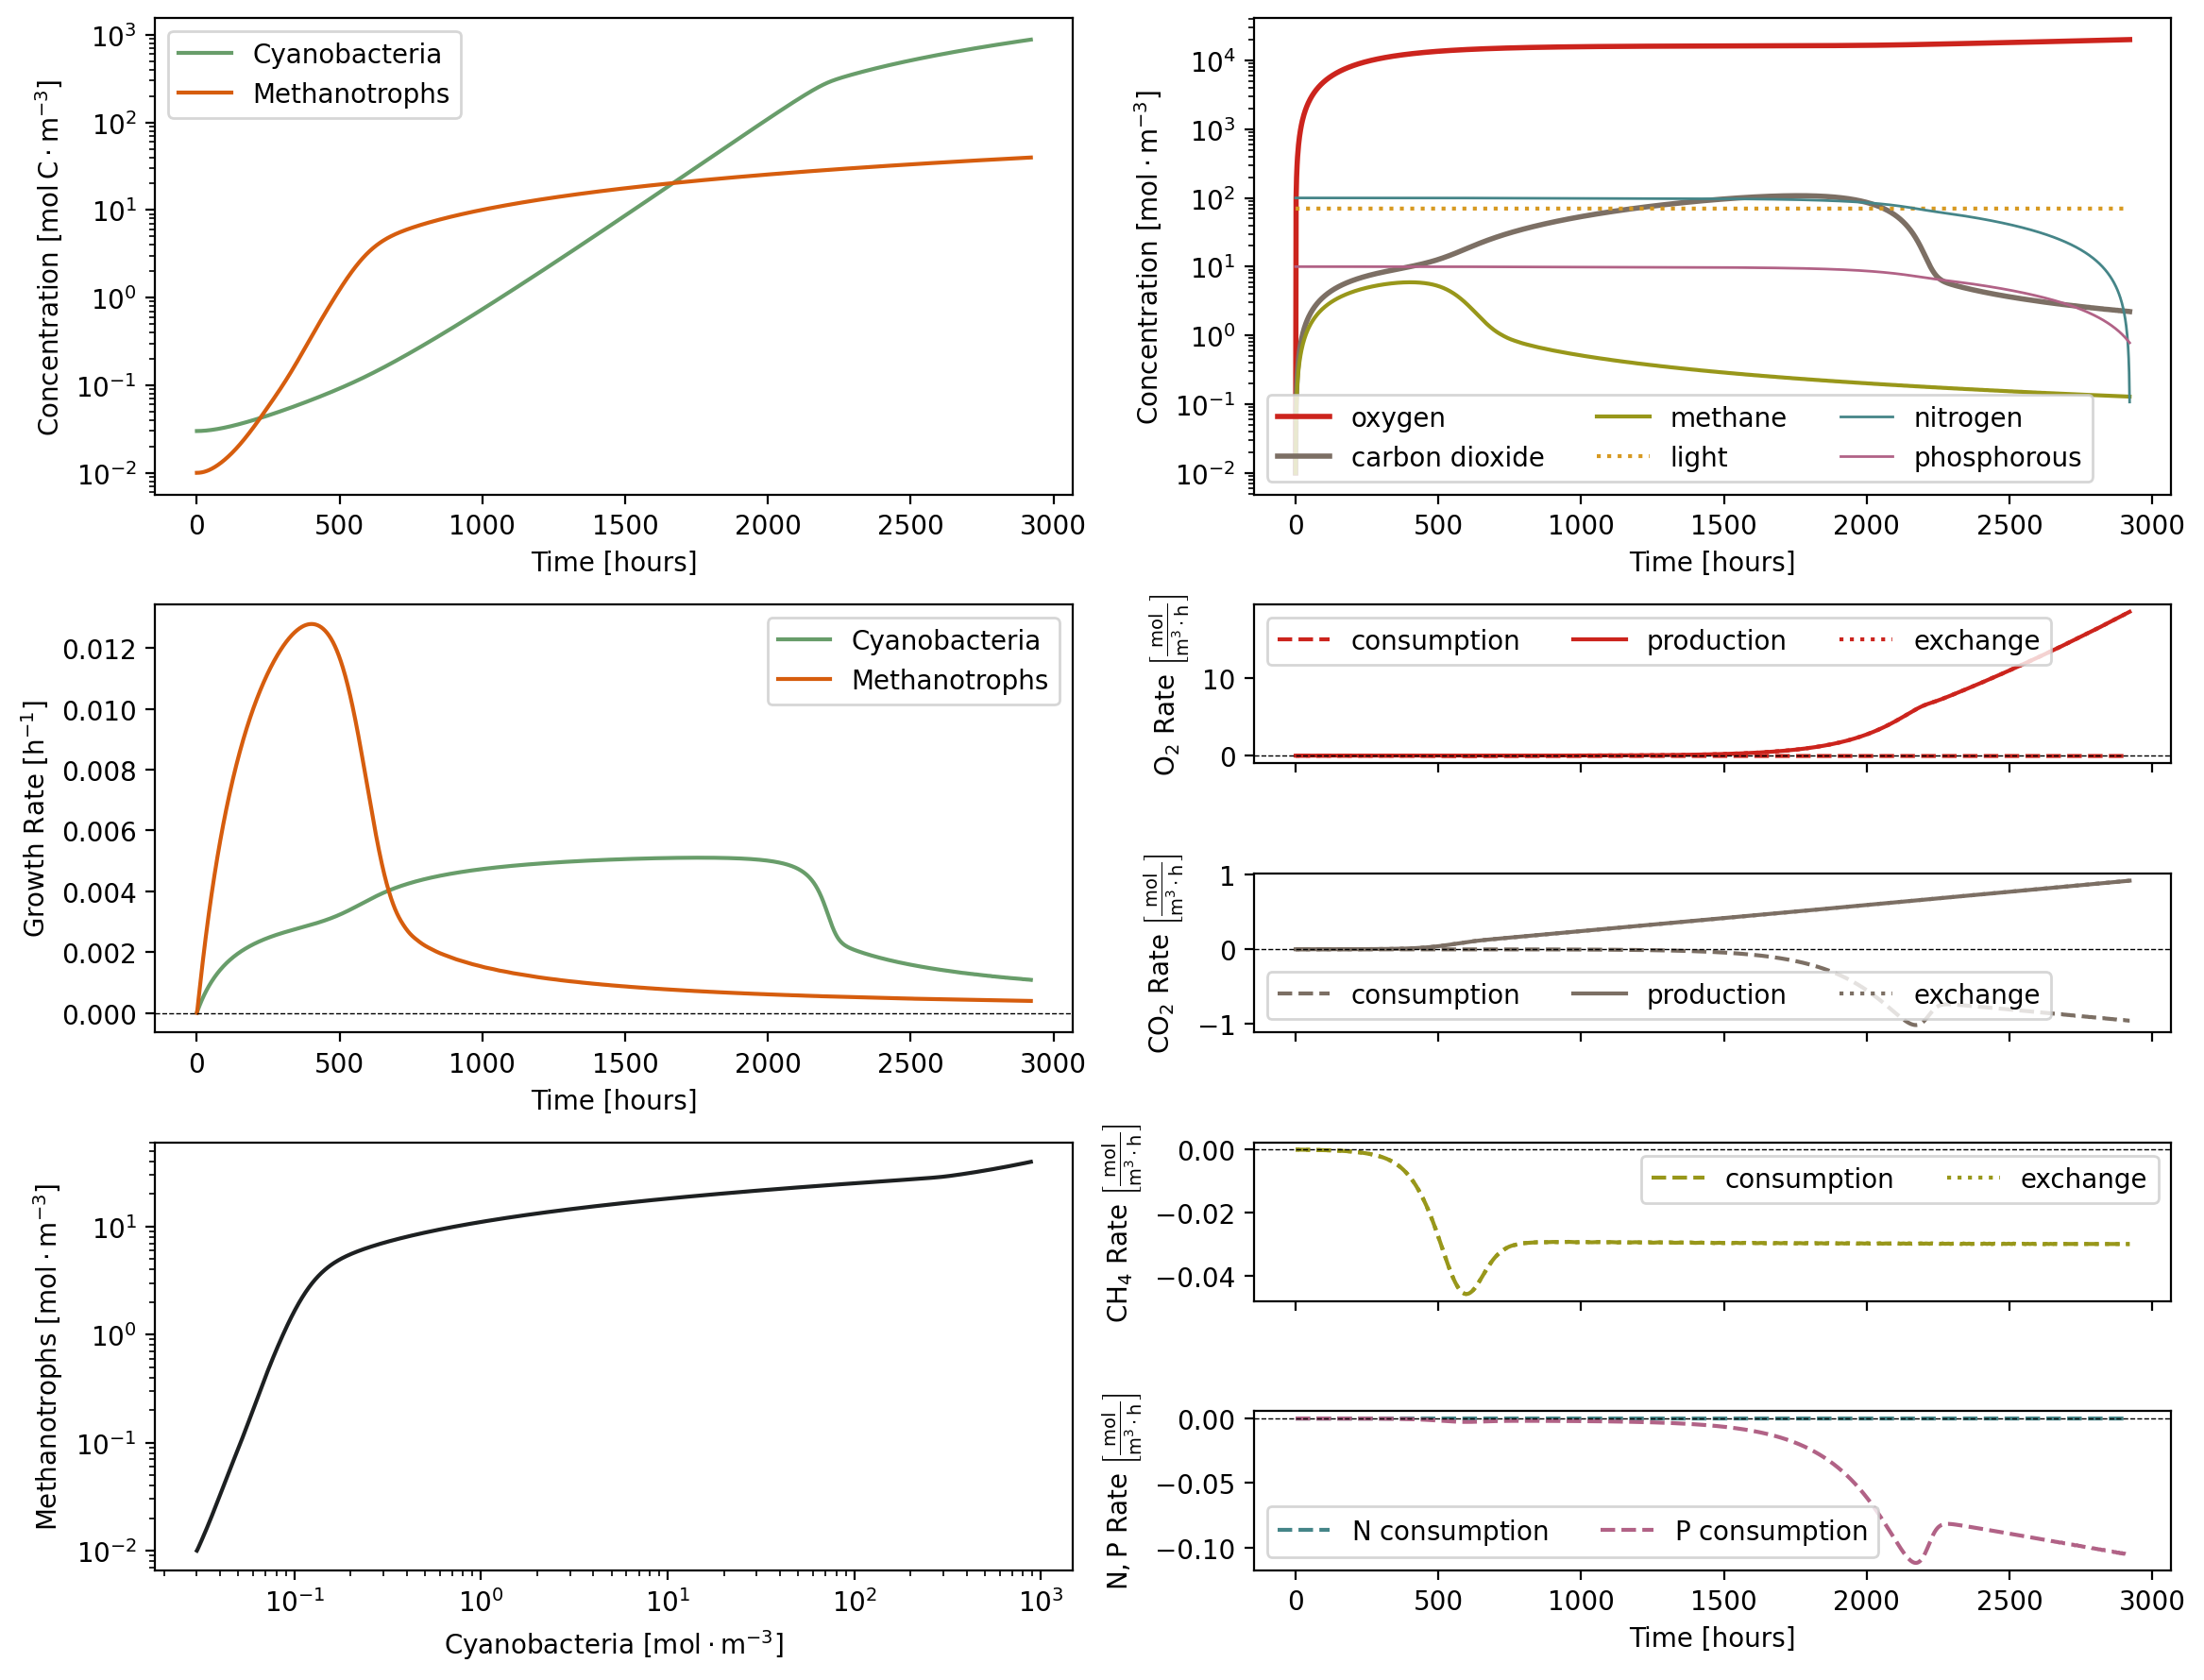

In [40]:
# Plot the results:
# left: Concentrations of Cyanobacteria (cyan: #689d6a) and Methanotrophs (orange: #d65d0e) over time.
# middle: Concentrations of oxygen (red: #cc241d), carbon dioxide (gray: #7c6f64) and methane (purple: #b16286) over time.
# right: Trajectory of the system in the concentration space of Cyanobacteria (x) and Methanotrophs (y).

fig = plt.figure( figsize=(12,9), dpi=200 )
axs = fig.add_gridspec( 5, 2, height_ratios=[3,1,1,1,1] )

ax = fig.add_subplot( axs[0,0] )
ax.plot(sol.t / 3600, sol.y[0], label='Cyanobacteria', color='#689d6a')
ax.plot(sol.t / 3600, sol.y[1], label='Methanotrophs', color='#d65d0e')
ax.set_xlabel('Time [hours]')
ax.set_ylabel('Concentration [$\mathrm{mol}\,\mathrm{C}\cdot\mathrm{m}^{-3}$]')
ax.set_yscale("log")
ax.legend()

ax = fig.add_subplot( axs[1:3,0] )
growth_rates = np.array( [ mu(*state) for state in sol.y.T ] ).T
ax.plot(sol.t / 3600, 3600*growth_rates[0], label='Cyanobacteria', color='#689d6a')
ax.plot(sol.t / 3600, 3600*growth_rates[1], label='Methanotrophs', color='#d65d0e')
ax.axhline(0, c='k', lw=0.5, ls='--')
ax.set_xlabel('Time [hours]')
ax.set_ylabel('Growth Rate $\left[\mathrm{h}^{-1}\\right]$')
ax.legend()

ax = fig.add_subplot( axs[3:5,0] )
ax.plot(sol.y[0], sol.y[1], color='#1d2021')
ax.set_xlabel('Cyanobacteria [$\mathrm{mol}\cdot\mathrm{m}^{-3}$]')
ax.set_ylabel('Methanotrophs [$\mathrm{mol}\cdot\mathrm{m}^{-3}$]')
ax.set_xscale("log")
ax.set_yscale("log")


ax = fig.add_subplot( axs[0,1] )
ax.plot(sol.t / 3600, sol.y[2], label='oxygen', color='#cc241d', lw=2)
ax.plot(sol.t / 3600, sol.y[3], label='carbon dioxide', color='#7c6f64', lw=2)
ax.plot(sol.t / 3600, sol.y[4], label='methane', color='#98971a', lw=1.5)
ax.plot(sol.t / 3600, sol.y[5], label='light', color='#d79921', lw=1.5, ls=':')
ax.plot(sol.t / 3600, sol.y[6], label='nitrogen', color='#458588', lw=1)
ax.plot(sol.t / 3600, sol.y[7], label='phosphorous', color='#b16286', lw=1)
ax.set_xlabel('Time [hours]')
ax.set_ylabel('Concentration [$\mathrm{mol}\cdot\mathrm{m}^{-3}$]')
ax.set_yscale("log")
ax.legend(ncols=3)

y_consumption_rates = np.array( [ consumption_rates(FIXED_PARAMS["inverse_yields"], (pCy,pMe)) for pCy,pMe in zip( growth_rates[0]*sol.y[0], growth_rates[1]*sol.y[1] ) ] ).T
y_production_rates = np.array( [ production_rates(FIXED_PARAMS["alpha"], FIXED_PARAMS["beta"], (Cy, Me), (pCy*Cy,pMe*Me)) for Cy,Me,pCy,pMe in zip( sol.y[0], sol.y[1], growth_rates[0], growth_rates[1] ) ] ).T
y_exchange_rates = np.array( 
    [ 
        gas_exchange_rates(
            FIXED_PARAMS["k_La"], { chem : ADJUSTABLE_PARAMS["p"][chem]/FIXED_PARAMS["H"][chem] for chem in ("O2", "CO2", "CH4") }, 
            (c_O2, c_CO2, c_CH4)
        ) for c_O2, c_CO2, c_CH4 in zip( sol.y[2], sol.y[3], sol.y[4] ) 
    ] 
).T

ax = fig.add_subplot( axs[1,1] )
ax.plot(sol.t / 3600, 3600*y_consumption_rates[0], label='consumption', color='#cc241d', ls='--')
ax.plot(sol.t / 3600, 3600*y_production_rates[0], label='production', color='#cc241d')
ax.plot(sol.t / 3600, 3600*y_production_rates[0], label='exchange', color='#cc241d', ls=':')
ax.axhline(0, c='k', lw=0.5, ls='--')
ax.set_ylabel('$\mathrm{O}_2$ Rate $\\left[ \\frac{ \mathrm{mol} }{ \mathrm{m}^{3}\cdot\mathrm{h} } \\right]$')
ax.set_xticklabels([])
ax.legend(ncols=3)

ax = fig.add_subplot( axs[2,1] )
ax.plot(sol.t / 3600, 3600*y_consumption_rates[1], label='consumption', color='#7c6f64', ls='--')
ax.plot(sol.t / 3600, 3600*y_production_rates[1], label='production', color='#7c6f64')
ax.plot(sol.t / 3600, 3600*y_production_rates[1], label='exchange', color='#7c6f64', ls=':')
ax.axhline(0, c='k', lw=0.5, ls='--')
ax.set_ylabel('$\mathrm{CO}_2$ Rate $\\left[ \\frac{ \mathrm{mol} }{ \mathrm{m}^{3}\cdot\mathrm{h} } \\right]$')
ax.set_xticklabels([])
ax.legend(ncols=3)

ax = fig.add_subplot( axs[3,1] )
ax.plot(sol.t / 3600, 3600*y_consumption_rates[2], label='consumption', color='#98971a', ls='--')
ax.plot(sol.t / 3600, 3600*y_consumption_rates[2], label='exchange', color='#98971a', ls=':')
ax.axhline(0, c='k', lw=0.5, ls='--')
ax.set_ylabel('$\mathrm{CH}_4$ Rate $\\left[ \\frac{ \mathrm{mol} }{ \mathrm{m}^{3}\cdot\mathrm{h} } \\right]$')
ax.set_xticklabels([])
ax.legend(ncols=2)

ax = fig.add_subplot( axs[4,1] )
ax.plot(sol.t / 3600, 3600*y_consumption_rates[3], label='$\mathrm{N}$ consumption', color='#458588', ls='--')
ax.plot(sol.t / 3600, 3600*y_consumption_rates[4], label='$\mathrm{P}$ consumption', color='#b16286', ls='--')
ax.axhline(0, c='k', lw=0.5, ls='--')
ax.set_ylabel('$\mathrm{N},\mathrm{P}$ Rate $\\left[ \\frac{ \mathrm{mol} }{ \mathrm{m}^{3}\cdot\mathrm{h} } \\right]$')
ax.legend(ncols=2)

ax.set_xlabel('Time [hours]')

plt.tight_layout()
plt.show()

fig.patch.set_alpha(0.0)
fig.savefig( "Cell Culture Dynamics v1.png", dpi=300, bbox_inches='tight', pad_inches=0.0 )

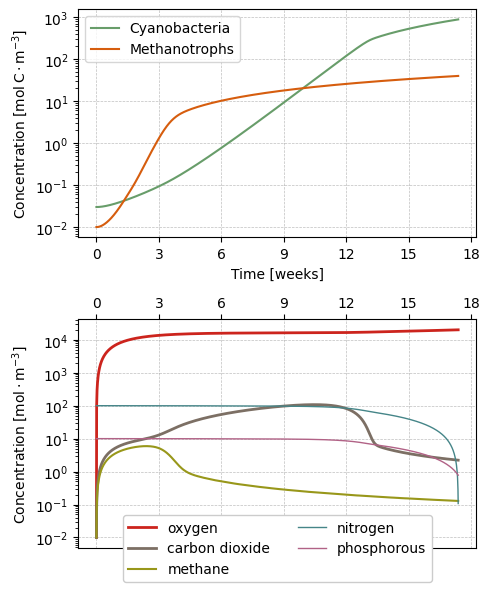

In [41]:
fig = plt.figure( figsize=(5,6), dpi=100 )
axs = fig.add_gridspec( 2, 1 )

hours = lambda seconds : seconds / 3600
days = lambda seconds : seconds / (3600*24)
weeks = lambda seconds : seconds / (3600*24*7)
time_unit_conv = weeks

ax = fig.add_subplot( axs[0,0] )
ax.plot( time_unit_conv(sol.t), sol.y[0], label='Cyanobacteria', color='#689d6a')
ax.plot( time_unit_conv(sol.t), sol.y[1], label='Methanotrophs', color='#d65d0e')
ax.set_xlabel('Time [weeks]')
ax.set_xticks( np.arange(0,weeks(sol.t[-1])+1,3))
ax.set_ylabel('Concentration [$\mathrm{mol}\,\mathrm{C}\cdot\mathrm{m}^{-3}$]')
ax.set_yscale("log")
ax.grid(ls='--', color='k', alpha=0.25, lw=0.5)
ax.legend()

ax = fig.add_subplot( axs[1,0] )
ax.plot( time_unit_conv(sol.t), sol.y[2], label='oxygen', color='#cc241d', lw=2)
ax.plot( time_unit_conv(sol.t), sol.y[3], label='carbon dioxide', color='#7c6f64', lw=2)
ax.plot( time_unit_conv(sol.t), sol.y[4], label='methane', color='#98971a', lw=1.5)
#ax.plot( time_unit_conv(sol.t), sol.y[5], label='light', color='#d79921', lw=1.5, ls=':')
ax.plot( time_unit_conv(sol.t), sol.y[6], label='nitrogen', color='#458588', lw=1)
ax.plot( time_unit_conv(sol.t), sol.y[7], label='phosphorous', color='#b16286', lw=1)
#ax.set_ylim(ymin=2e-1, ymax=3e4)
#ax.set_xlabel('Time [hours]')
ax.grid(ls='--', color='k', alpha=0.25, lw=0.5)
ax.xaxis.tick_top()
ax.set_xticks( np.arange(0,weeks(sol.t[-1])+1,3))
ax.set_ylabel('Concentration [$\mathrm{mol}\cdot\mathrm{m}^{-3}$]')
ax.set_yscale("log")
ax.legend(ncols=2, loc='lower center', bbox_to_anchor=(0.5,-0.18), framealpha=1.0)

plt.tight_layout()
plt.show()

fig.patch.set_alpha(0.0)
fig.savefig( "Cell Culture Dynamics v2.png", dpi=600, bbox_inches='tight', pad_inches=0.1 )

In [44]:
SAMPLES_PER_AXIS = 257
#SAMPLES_PER_AXIS = 65

SAMPLING_RANGES = {
    # "METHANE_SUPPLY" : np.linspace(0.00, 0.06, 1+(6*4)),
    "METHANE_SUPPLY" : np.logspace(-4.85, -1.25, SAMPLES_PER_AXIS),
    "LIGHT_INTENSITY" : np.linspace(0.0, 2000, 17),
    "STARTING_MICROBE_RATIO" : np.logspace(-3, 3, SAMPLES_PER_AXIS, base=10)
}

In [45]:
limiting_ratios = {}
for param in SAMPLING_RANGES:
    limiting_ratios[param] = np.zeros_like( SAMPLING_RANGES[param] )

In [63]:
methane_partial_pressure = 0.0025

ADJUSTABLE_PARAMS = { "p" : { "O2" : 0.20946, "CO2" : 0.00407, "N" : 0.78084, }, "light_intensity" : 1000, }

for gas in ADJUSTABLE_PARAMS["p"]:
    ADJUSTABLE_PARAMS["p"][gas] /= 1+methane_partial_pressure
ADJUSTABLE_PARAMS["p"]["CH4"] = methane_partial_pressure
del ADJUSTABLE_PARAMS["p"]["N"]

params = QUANTITIES, FIXED_PARAMS, ADJUSTABLE_PARAMS
mu,consumption_rates,production_rates,gas_exchange_rates,ode_system = gen_ode(*params)

In [64]:
for i,starting_ratio in enumerate(SAMPLING_RANGES["STARTING_MICROBE_RATIO"]):
    c_Cy_0 = 4.0e-2 * starting_ratio / (1+starting_ratio)
    c_Me_0 = 4.0e-2 / (1+starting_ratio)
    #print( f"Cy: {c_Cy_0}, Me: {c_Me_0}, Σ: {c_Cy_0+c_Me_0}" )

    y0 = [c_Cy_0, c_Me_0, c_O2_0, c_CO2_0, c_CH4_0, c_L_0, c_N_0, c_P_0]

    sol = solve_ivp(ode_system, t_span, y0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], num=10000), events=EVENTS)

    limiting_ratios["STARTING_MICROBE_RATIO"][i] = sol.y[0][-1] / sol.y[1][-1]

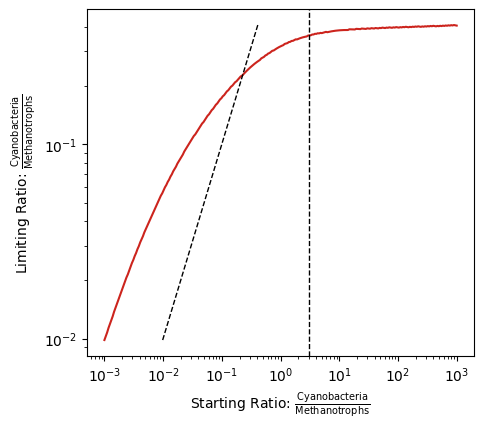

In [71]:
fig = plt.figure( figsize=(5,4.5), dpi=100 )
axs = fig.add_gridspec( 1, 1 )

ax = fig.add_subplot(axs[0,0])

ax.plot(SAMPLING_RANGES["STARTING_MICROBE_RATIO"], limiting_ratios["STARTING_MICROBE_RATIO"], color='#cc241d')
ax.plot( *np.array( [
        [ max( np.min(SAMPLING_RANGES["STARTING_MICROBE_RATIO"]), np.min(limiting_ratios["STARTING_MICROBE_RATIO"]) ) ]*2, 
        [ min( np.max(SAMPLING_RANGES["STARTING_MICROBE_RATIO"]), np.max(limiting_ratios["STARTING_MICROBE_RATIO"]) ) ]*2, 
    ] ).T,
    color='k', ls='--', lw=1
)
ax.axvline(3.0, c='k', ls='--', lw=1)

ax.set_xlabel("Starting Ratio: $\\frac{\mathrm{Cyanobacteria}}{\mathrm{Methanotrophs}}$")
ax.set_ylabel("Limiting Ratio: $\\frac{\mathrm{Cyanobacteria}}{\mathrm{Methanotrophs}}$")

ax.set_xscale('log')
ax.set_yscale('log')

In [58]:
for i,methane_partial_pressure in enumerate(SAMPLING_RANGES["METHANE_SUPPLY"]):
    ADJUSTABLE_PARAMS = { "p" : { "O2" : 0.20946, "CO2" : 0.00407, "N" : 0.78084, }, "light_intensity" : 1000, }

    for gas in ADJUSTABLE_PARAMS["p"]:
        ADJUSTABLE_PARAMS["p"][gas] /= 1+methane_partial_pressure
    ADJUSTABLE_PARAMS["p"]["CH4"] = methane_partial_pressure
    del ADJUSTABLE_PARAMS["p"]["N"]

    params = QUANTITIES, FIXED_PARAMS, ADJUSTABLE_PARAMS
    mu,consumption_rates,production_rates,gas_exchange_rates,ode_system = gen_ode(*params)

    c_Cy_0 = 3.0e-2
    c_Me_0 = 1.0e-2
    y0 = [c_Cy_0, c_Me_0, c_O2_0, c_CO2_0, c_CH4_0, c_L_0, c_N_0, c_P_0]

    sol = solve_ivp(ode_system, t_span, y0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], num=10000), events=EVENTS)

    limiting_ratios["METHANE_SUPPLY"][i] = sol.y[0][-1] / sol.y[1][-1]

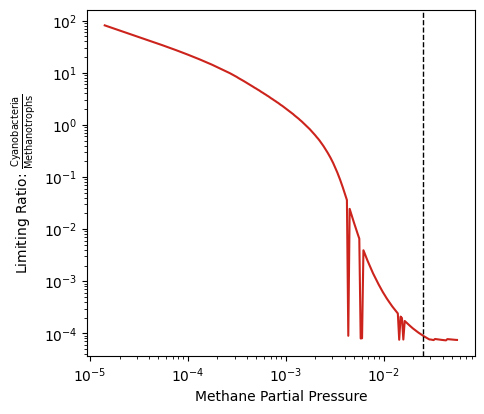

In [59]:
fig = plt.figure( figsize=(5,4.5), dpi=100 )
axs = fig.add_gridspec( 1, 1 )

ax = fig.add_subplot(axs[0,0])

ax.plot(SAMPLING_RANGES["METHANE_SUPPLY"], limiting_ratios["METHANE_SUPPLY"], color='#cc241d')
ax.axvline(0.025, c='k', ls='--', lw=1)

ax.set_xlabel("Methane Partial Pressure")
ax.set_ylabel("Limiting Ratio: $\\frac{\mathrm{Cyanobacteria}}{\mathrm{Methanotrophs}}$")

ax.set_xscale('log')
ax.set_yscale('log')

In [50]:
X,Y = np.meshgrid( SAMPLING_RANGES["STARTING_MICROBE_RATIO"], SAMPLING_RANGES["METHANE_SUPPLY"] )
Z = np.zeros_like(X)
T = np.zeros_like(X)

for x in range(Z.shape[0]):
    for y in range(Z.shape[1]):
        starting_ratio, methane_partial_pressure = X[x,y], Y[x,y]

        ADJUSTABLE_PARAMS = { "p" : { "O2" : 0.20946, "CO2" : 0.00407, "N" : 0.78084, }, "light_intensity" : 1000, }

        for gas in ADJUSTABLE_PARAMS["p"]:
            ADJUSTABLE_PARAMS["p"][gas] /= 1+methane_partial_pressure
        ADJUSTABLE_PARAMS["p"]["CH4"] = methane_partial_pressure
        del ADJUSTABLE_PARAMS["p"]["N"]

        params = QUANTITIES, FIXED_PARAMS, ADJUSTABLE_PARAMS
        mu,consumption_rates,production_rates,gas_exchange_rates,ode_system = gen_ode(*params)

        c_Cy_0 = 4.0e-2 * starting_ratio / (1+starting_ratio)
        c_Me_0 = 4.0e-2 / (1+starting_ratio)
        y0 = [c_Cy_0, c_Me_0, c_O2_0, c_CO2_0, c_CH4_0, c_L_0, c_N_0, c_P_0]

        sol = solve_ivp(ode_system, t_span, y0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], num=10000), events=EVENTS)

        Z[x,y] = sol.y[0][-1] / sol.y[1][-1]
        T[x,y] = sol.t[-1]

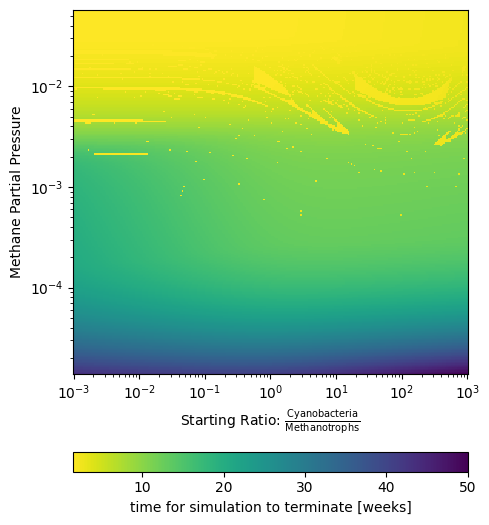

In [51]:
fig = plt.figure( figsize=(5,5.5), dpi=100 )
axs = fig.add_gridspec( 1, 1 )

ax = fig.add_subplot(axs[0,0])

im = plt.pcolor( X, Y, weeks(T), cmap='viridis_r', norm=mpl.colors.Normalize())
#ax.axhline(2.8e-4, color='k', ls='--', lw=2)
#ax.text(1e0, 2.8e-4, "Ratio remains stable", va='bottom', ha='center')

ax.set_xlabel("Starting Ratio: $\\frac{\mathrm{Cyanobacteria}}{\mathrm{Methanotrophs}}$")
ax.set_ylabel("Methane Partial Pressure")
#ax.axvline(1, c='k', ls=':', lw=0.5)
#ax.axhline(0.05, c='k', ls=':', lw=0.5)
#ax.plot(X[0,boundary], Y[:,0], c='k', ls='--', lw=0.5)

cbar = plt.colorbar(im, orientation='horizontal', label="time for simulation to terminate [weeks]")
#cbar.ax.set_xlabel("Final Ratio: $\\frac{\mathrm{Cyanobacteria}}{\mathrm{Methanotrophs}}$")
#cbar.ax.axvline(1, c='k', ls='--', lw=0.5)
#cbar.ax.axhspan(np.max(Z), 10**logrange, color="w", lw=0)
#cbar.ax.axhspan(np.min(Z), 10**-logrange, color="w", lw=0)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()
plt.show()

fig.patch.set_alpha(0.0)
fig.savefig( "Cell Culture Termination Time.png", dpi=300, bbox_inches='tight', pad_inches=0.0 )

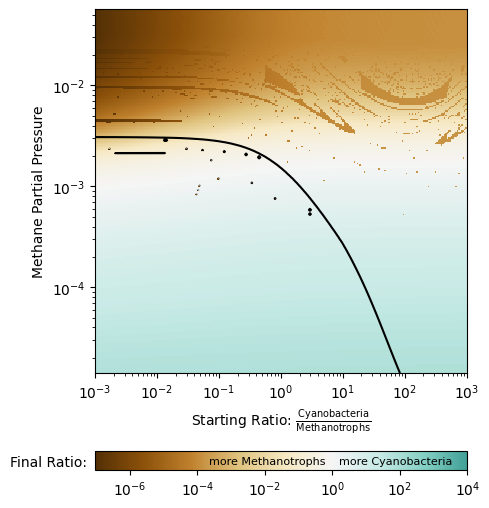

In [55]:
fig = plt.figure( figsize=(5,5.5), dpi=100 )
axs = fig.add_gridspec( 1, 1 )

ax = fig.add_subplot(axs[0,0])

logrange = np.max(np.abs(np.log10(Z)))
boundary = np.argmin(np.abs(np.log(Z)), axis=1)
im = plt.pcolor( X, Y, Z, cmap='BrBG', norm=mpl.colors.LogNorm(vmin=10**-logrange, vmax=10**logrange))
# plt.contour( 
#     X, Y, Z, 
#     colors='w', alpha=0.75,
#     linewidths=[ 0.8 if i!=0 else 1.5 for i in range(-6,7) ],
#     levels=np.logspace(-6,8,15,base=10),  
# )
# plt.contour( 
#     X, Y, Z, 
#     colors='w', alpha=0.75,
#     linewidths=0.5,
#     linestyles='--',
#     levels=[ l for l in np.logspace(-7,8,46,base=10) if l not in np.logspace(-6,8,15,base=10) ],  
# )

plt.contour( 
    X, Y, Z/X, 
    colors='k', 
    linewidths=[ 1.5 ], linestyles='-',
    levels=[1],  
)

#ax.axhline(2.8e-4, color='k', ls='--', lw=2)
#ax.text(1e0, 2.8e-4, "Ratio remains stable", va='bottom', ha='center')

ax.set_xlabel("Starting Ratio: $\\frac{\mathrm{Cyanobacteria}}{\mathrm{Methanotrophs}}$")
ax.set_ylabel("Methane Partial Pressure")
#ax.axvline(1, c='k', ls=':', lw=0.5)
#ax.axhline(0.05, c='k', ls=':', lw=0.5)
#ax.plot(X[0,boundary], Y[:,0], c='k', ls='--', lw=0.5)

cbar = plt.colorbar(im, orientation='horizontal', format=mpl.ticker.LogFormatterMathtext())
#cbar.ax.set_xlabel("Final Ratio: $\\frac{\mathrm{Cyanobacteria}}{\mathrm{Methanotrophs}}$")
cbar.ax.set_ylabel("Final Ratio: ", rotation=0, va='center_baseline', labelpad=32)
#cbar.ax.axvline(1, c='k', ls='--', lw=0.5)
#cbar.ax.axhspan(np.max(Z), 10**logrange, color="w", lw=0)
#cbar.ax.axhspan(np.min(Z), 10**-logrange, color="w", lw=0)
cbar.ax.set_xlim( xmin=min(1e-4,np.min(Z)), xmax=max(1e4,np.max(Z)) )
cbar.ax.text(1, 0.5, "  more Cyanobacteria", size=8, ha='left',  va='center_baseline')
cbar.ax.text(1, 0.5, "more Methanotrophs  ", size=8, ha='right', va='center_baseline')

ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()
plt.show()

fig.patch.set_alpha(0.0)
fig.savefig( "Cell Culture Phase Diagram v3.png", dpi=300, bbox_inches='tight', pad_inches=0.0 )

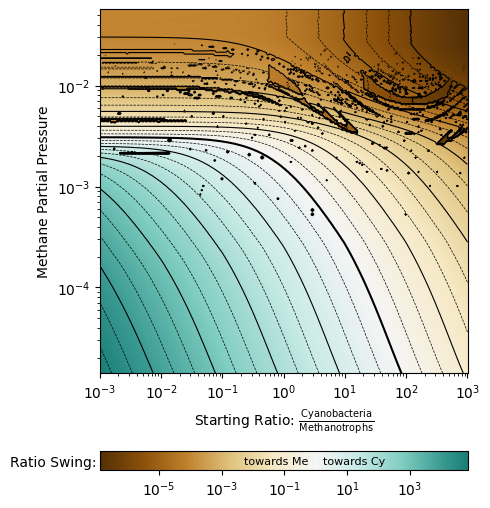

In [53]:
Z2 = Z / X

fig = plt.figure( figsize=(5,5.5), dpi=100 )
axs = fig.add_gridspec( 1, 1 )

ax = fig.add_subplot(axs[0,0])

logrange = np.max(np.abs(np.log10(Z2)))
boundary = np.argmin(np.abs(np.log(Z2)), axis=1)
im = plt.pcolor( X, Y, Z2, cmap='BrBG', norm=mpl.colors.LogNorm(vmin=10**-logrange, vmax=10**logrange))
plt.contour( 
    X, Y, Z2, 
    colors='k', 
    linewidths=[ 0.8 if i!=0 else 1.5 for i in range(-6,7) ],
    levels=np.logspace(-6,6,13,base=10),  
)
plt.contour( 
    X, Y, Z2, 
    colors='k', 
    linewidths=0.5,
    linestyles='--',
    levels=[ l for l in np.logspace(-6,6,37,base=10) if l not in np.logspace(-6,6,13,base=10) ],  
)

ax.set_xlabel("Starting Ratio: $\\frac{\mathrm{Cyanobacteria}}{\mathrm{Methanotrophs}}$")
ax.set_ylabel("Methane Partial Pressure")
#ax.set_title("Microbial Balance Swing")

cbar = plt.colorbar(im, orientation='horizontal',format=mpl.ticker.LogFormatterMathtext())
#cbar.ax.set_xlabel("Final Ratio: $\\frac{\mathrm{Cyanobacteria}}{\mathrm{Methanotrophs}}$")
cbar.ax.set_ylabel("Ratio Swing: ", rotation=0, va='center_baseline', labelpad=32)
#cbar.ax.axvline(1, c='k', ls='--', lw=0.5)
#cbar.ax.axhspan(np.max(Z2), 10**logrange, color="w", lw=0)
#cbar.ax.axhspan(np.min(Z2), 10**-logrange, color="w", lw=0)
cbar.ax.set_xlim( xmin=np.min(Z2), xmax=np.max(Z2) )
cbar.ax.text(1, 0.5, "  towards Cy", size=8, ha='left',  va='center_baseline')
cbar.ax.text(1, 0.5, "towards Me  ", size=8, ha='right', va='center_baseline')

ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()
plt.show()

fig.patch.set_alpha(0.0)
fig.savefig( "Cell Culture Balance Swing v1.png", dpi=300, bbox_inches='tight', pad_inches=0.0 )